In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import evotsc

In [3]:
# Population-level constants
genome_size = 10_000
gene_length = 100
intergene = 900
interaction_dist = 2500

In [4]:
def generate_genes(nb_genes, gene_length, intergene):
    genes = []

    for gene in range(nb_genes):
        new_gene = evotsc.Gene(length=gene_length,
                               intergene=intergene,
                               orientation=np.random.randint(2),
                               basal_expression=np.random.random()) 
        genes.append(new_gene)

    return genes

In [5]:
def plot_expr(temporal_expr, fitness, plot_name):
    nb_genes, nb_steps = temporal_expr.shape
    
    #colormap = mpl.cm.get_cmap('viridis', nb_genes)(range(nb_genes))
    
    plt.figure(figsize=(9, 6), dpi=200)
    
    for gene in range(nb_genes):
        linestyle = 'solid' if genes[gene].orientation == 0 else 'dashed'
        plt.plot(temporal_expr[gene, :],
                 linestyle=linestyle,
                 #color=colormap[gene],
                 label=f'Gene {gene}')
    
    plt.grid(linestyle=':')
    plt.xlabel('Time', fontsize='large')
    plt.ylabel('Expression level', fontsize='large')
    
    plt.legend(loc='center right')
    plt.title(f'Fitness: {fitness:.2}')
        
    plt.savefig(plot_name, dpi=300, bbox_inches='tight')

In [6]:
genes = generate_genes(nb_genes=10, gene_length=gene_length, intergene=intergene)

In [7]:
indiv = evotsc.Individual(genes=genes, interaction_dist=interaction_dist, nb_eval_steps=16)

In [8]:
res, fitness = indiv.evaluate()

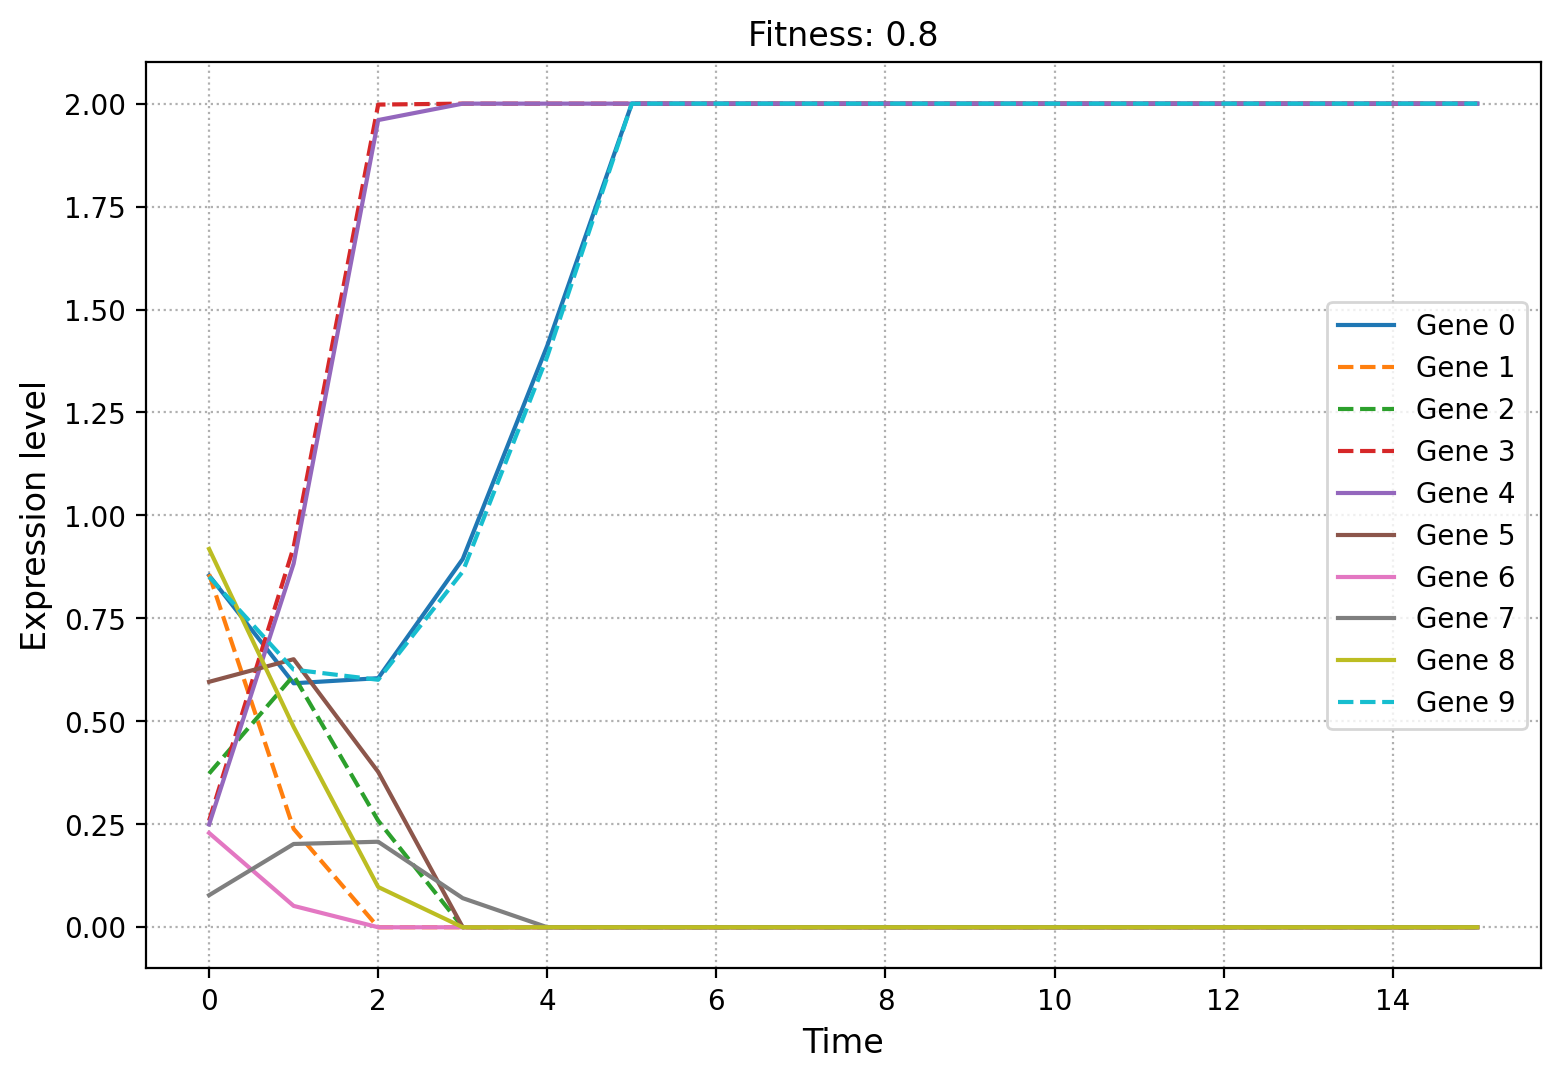

In [9]:
plot_expr(res, fitness, 'baseline')

In [10]:
def switch_1_gene(individual):
    for i_switched_gene in range(len(genes)):
        # Switch the current gene 
        to_switch = individual.genes[i_switched_gene]
        to_switch.orientation = 1 - to_switch.orientation

        # Run the switched system and plot
        switch_res, switch_fit = individual.evaluate()
        print(f'Switched gene {i_switched_gene}, fitness: {switch_fit}')
        plot_expr(switch_res, switch_fit, f'switched_{i_switched_gene}')

        # Reset the gene to its former orientation
        to_switch.orientation = 1 - to_switch.orientation

Switched gene 0, fitness: 0.40522633304883743
Switched gene 1, fitness: 0.8
Switched gene 2, fitness: 0.8
Switched gene 3, fitness: 0.8091696761489182
Switched gene 4, fitness: 0.8
Switched gene 5, fitness: 0.8196684910188989
Switched gene 6, fitness: 0.8
Switched gene 7, fitness: 0.8
Switched gene 8, fitness: 0.8
Switched gene 9, fitness: 0.4


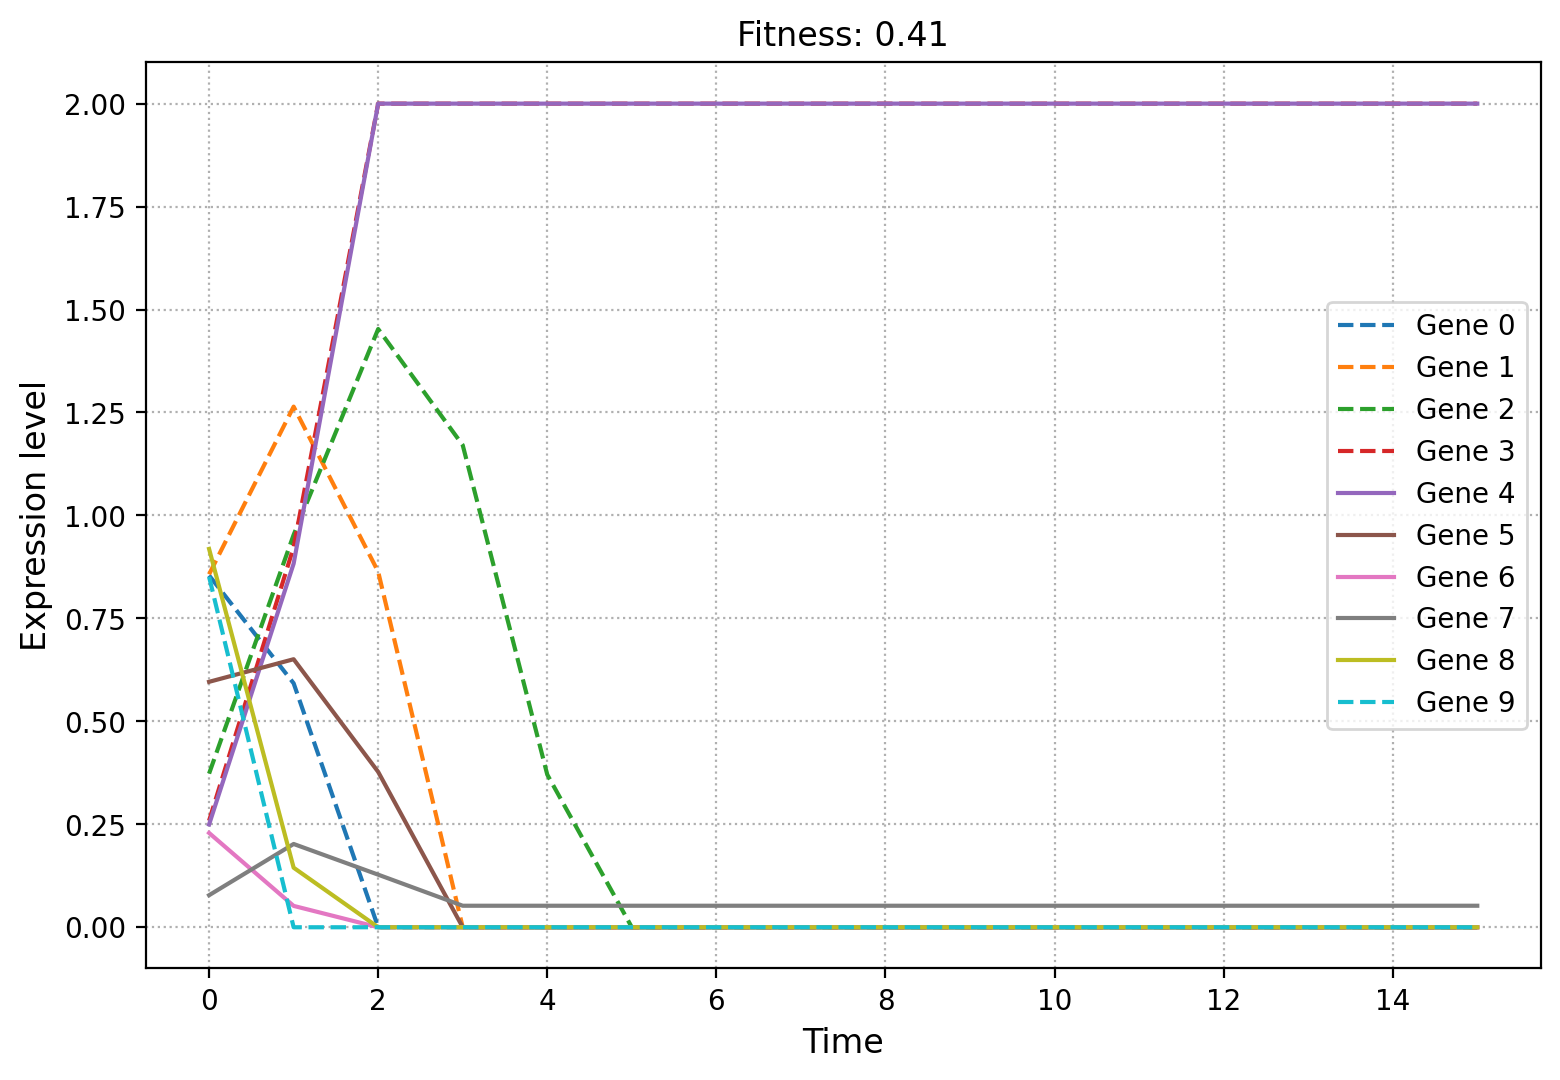

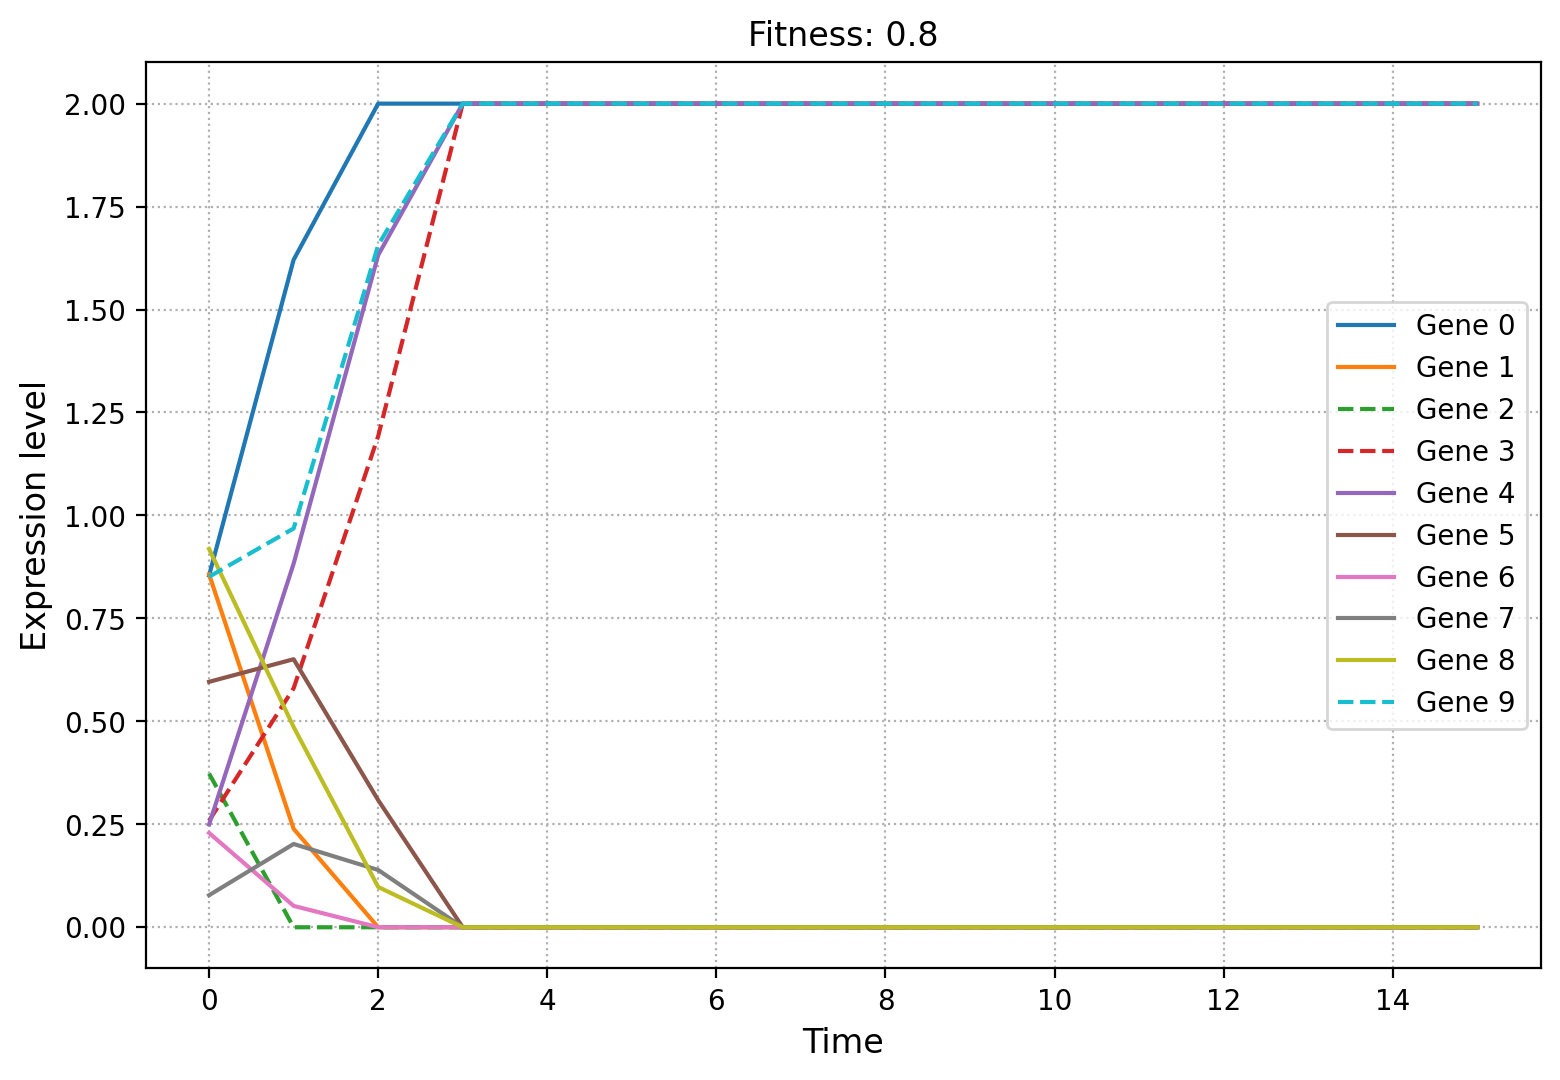

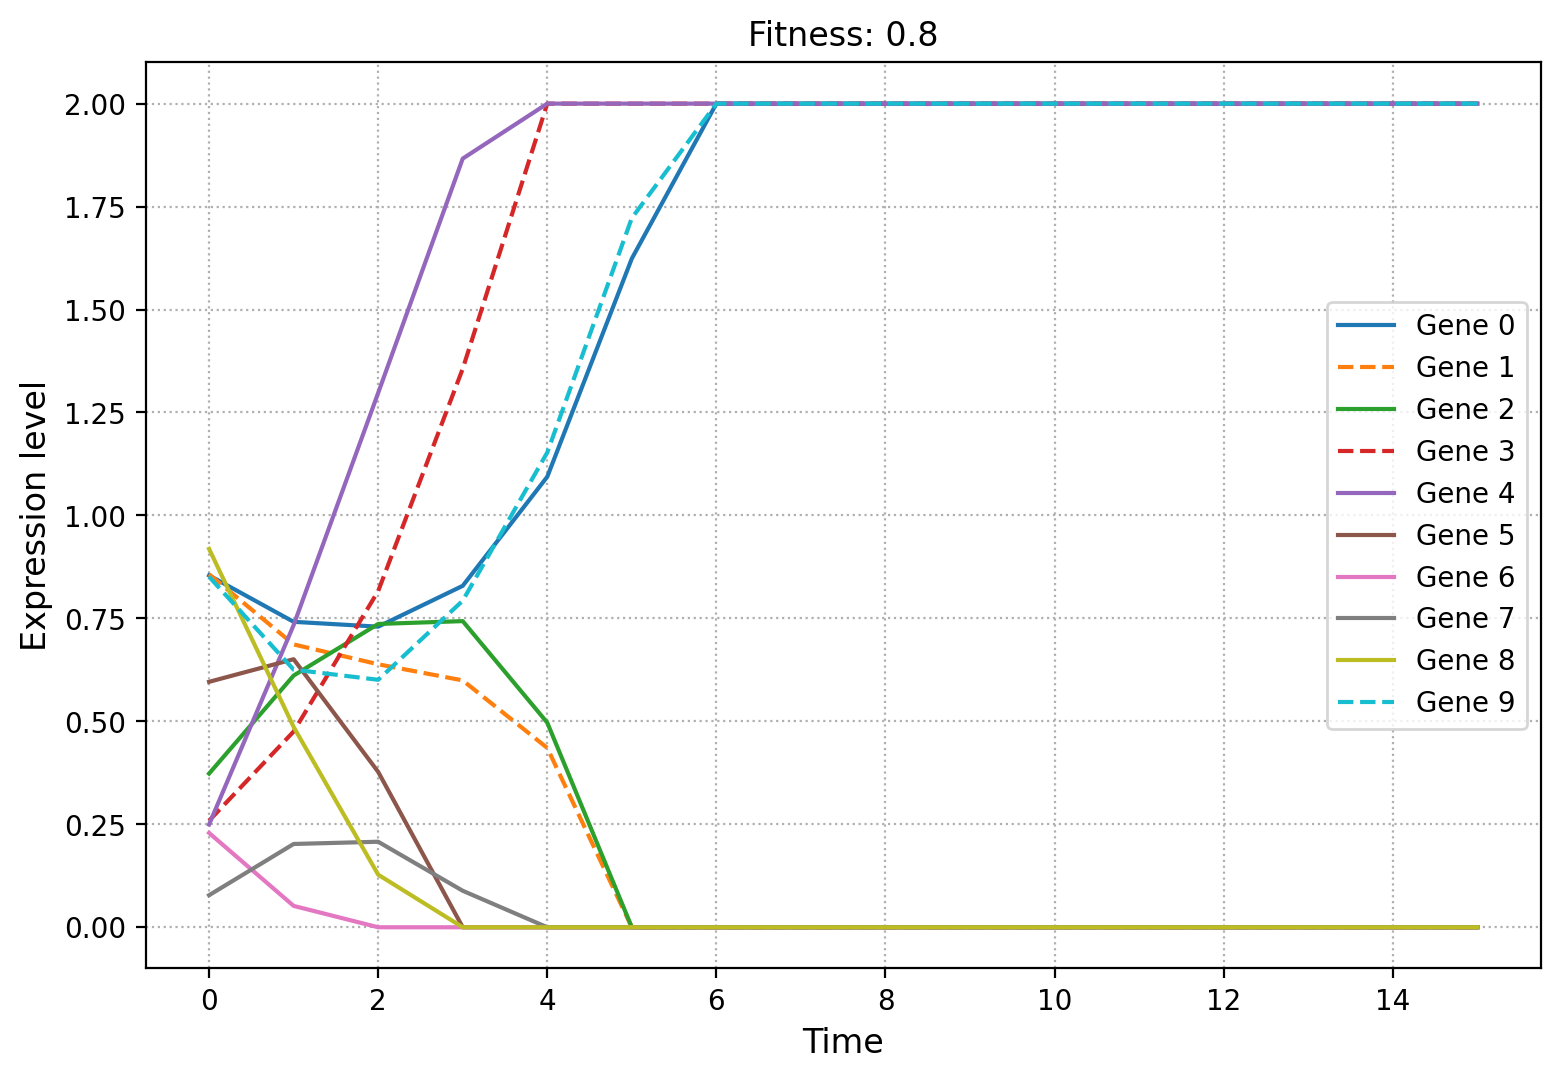

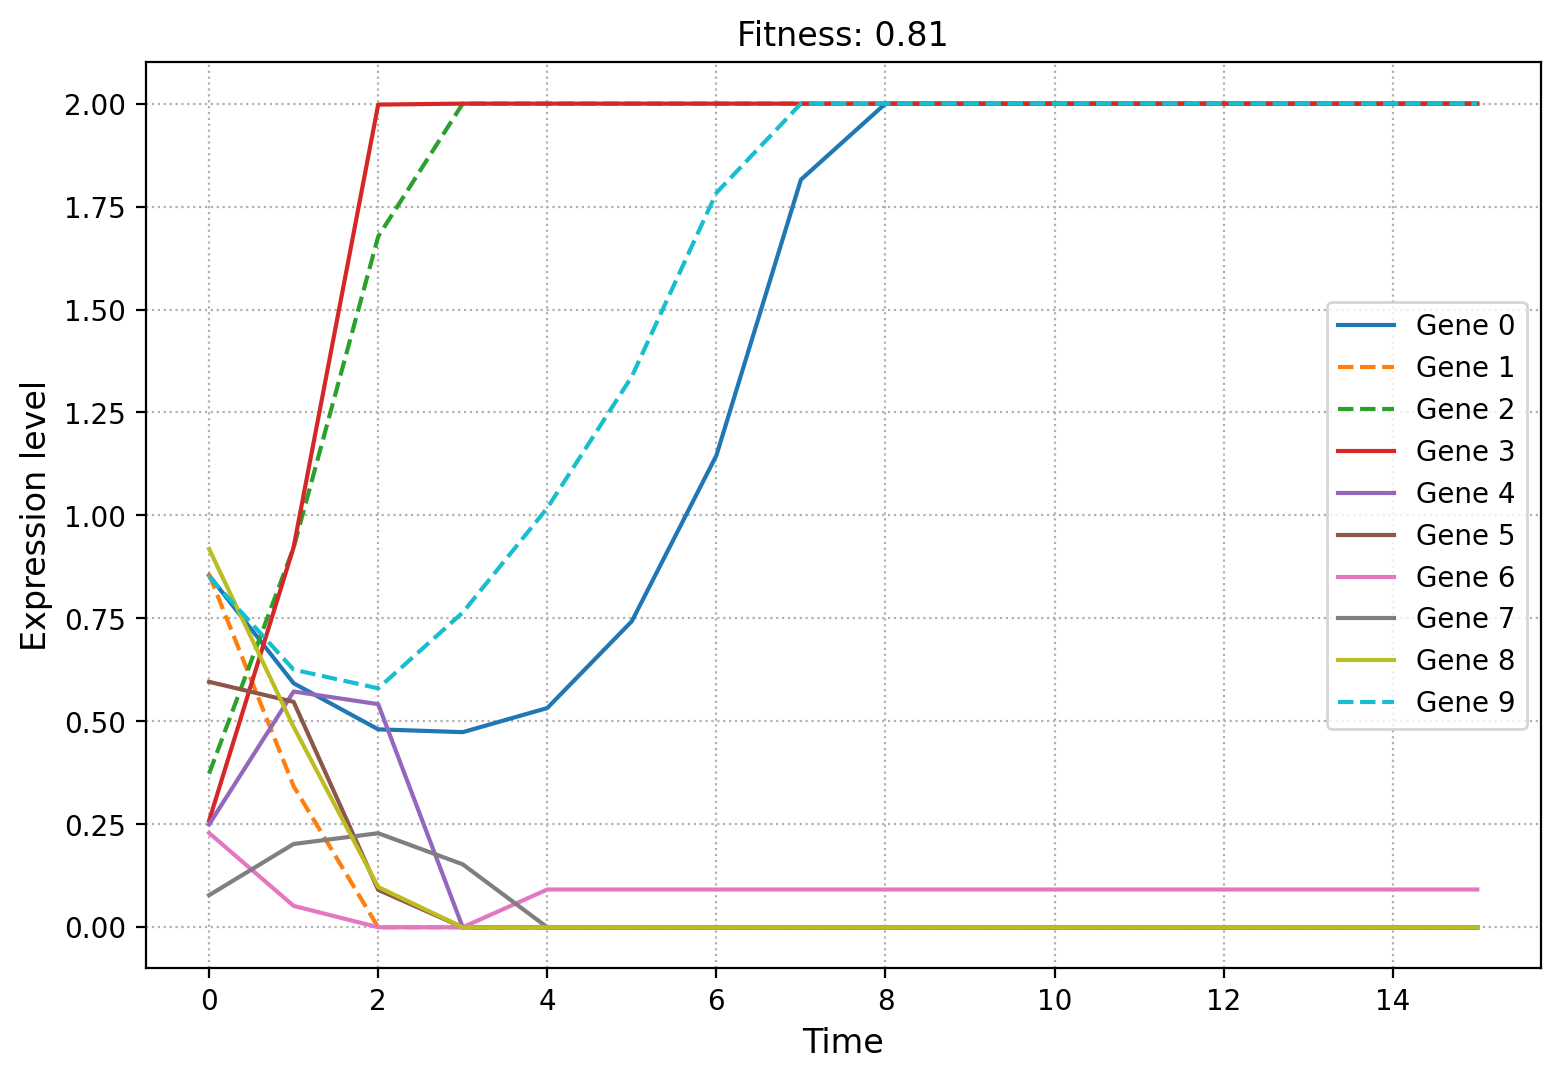

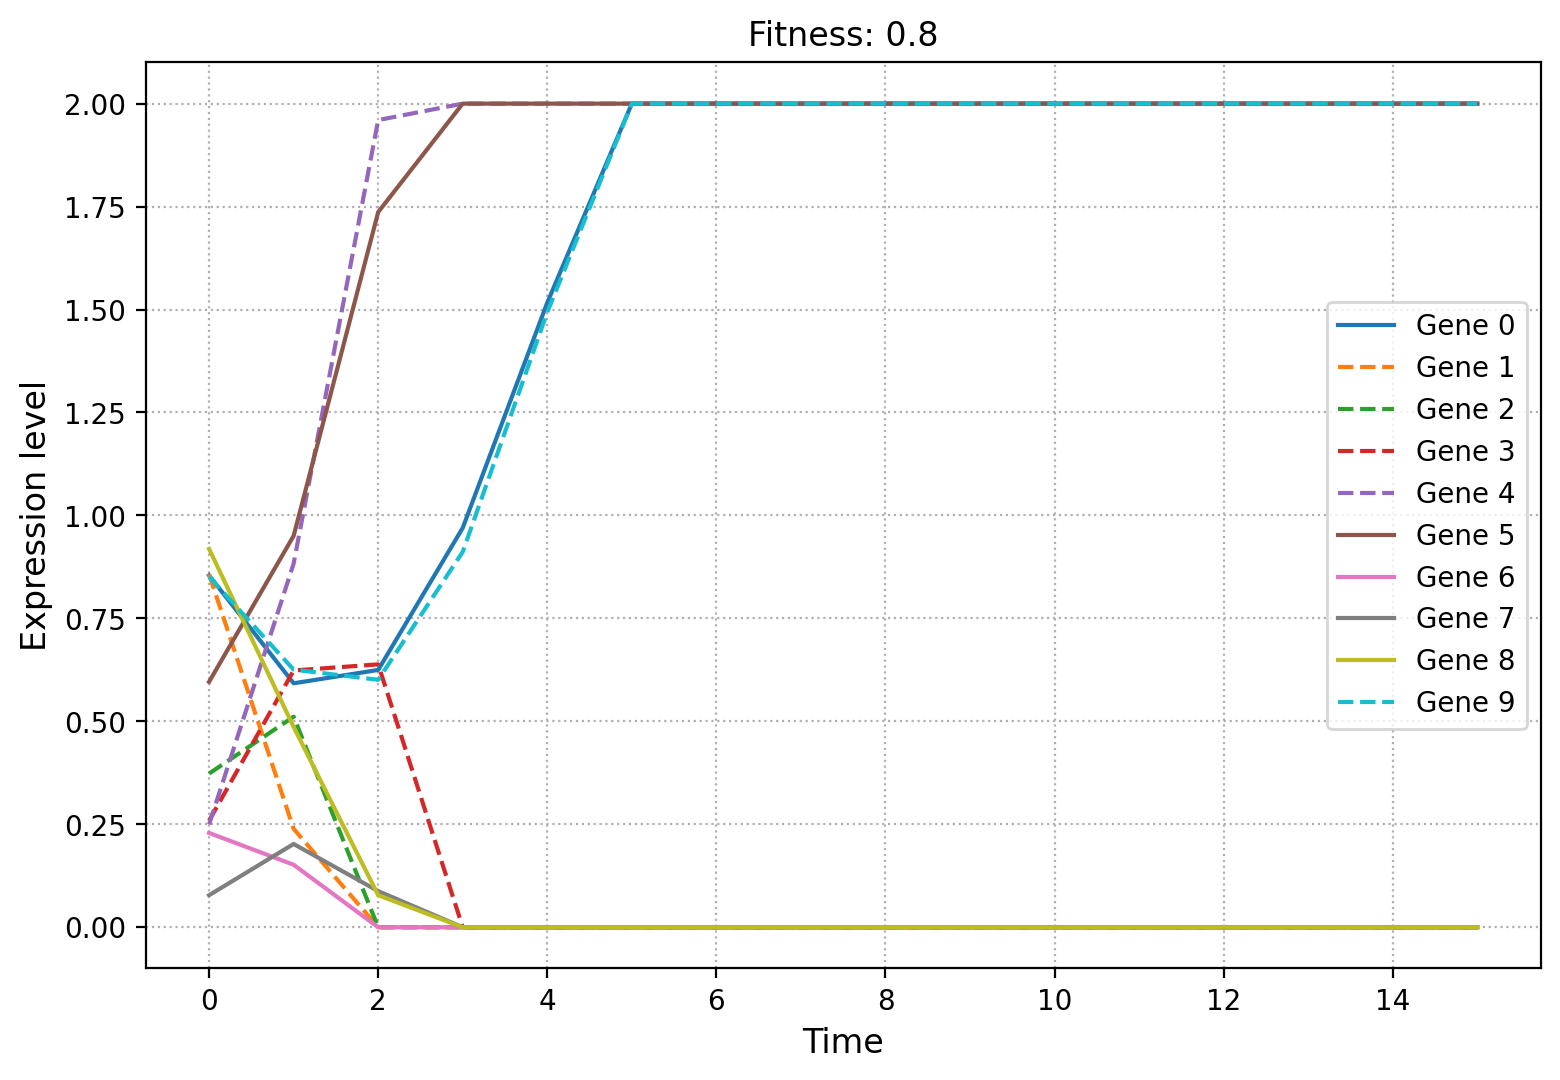

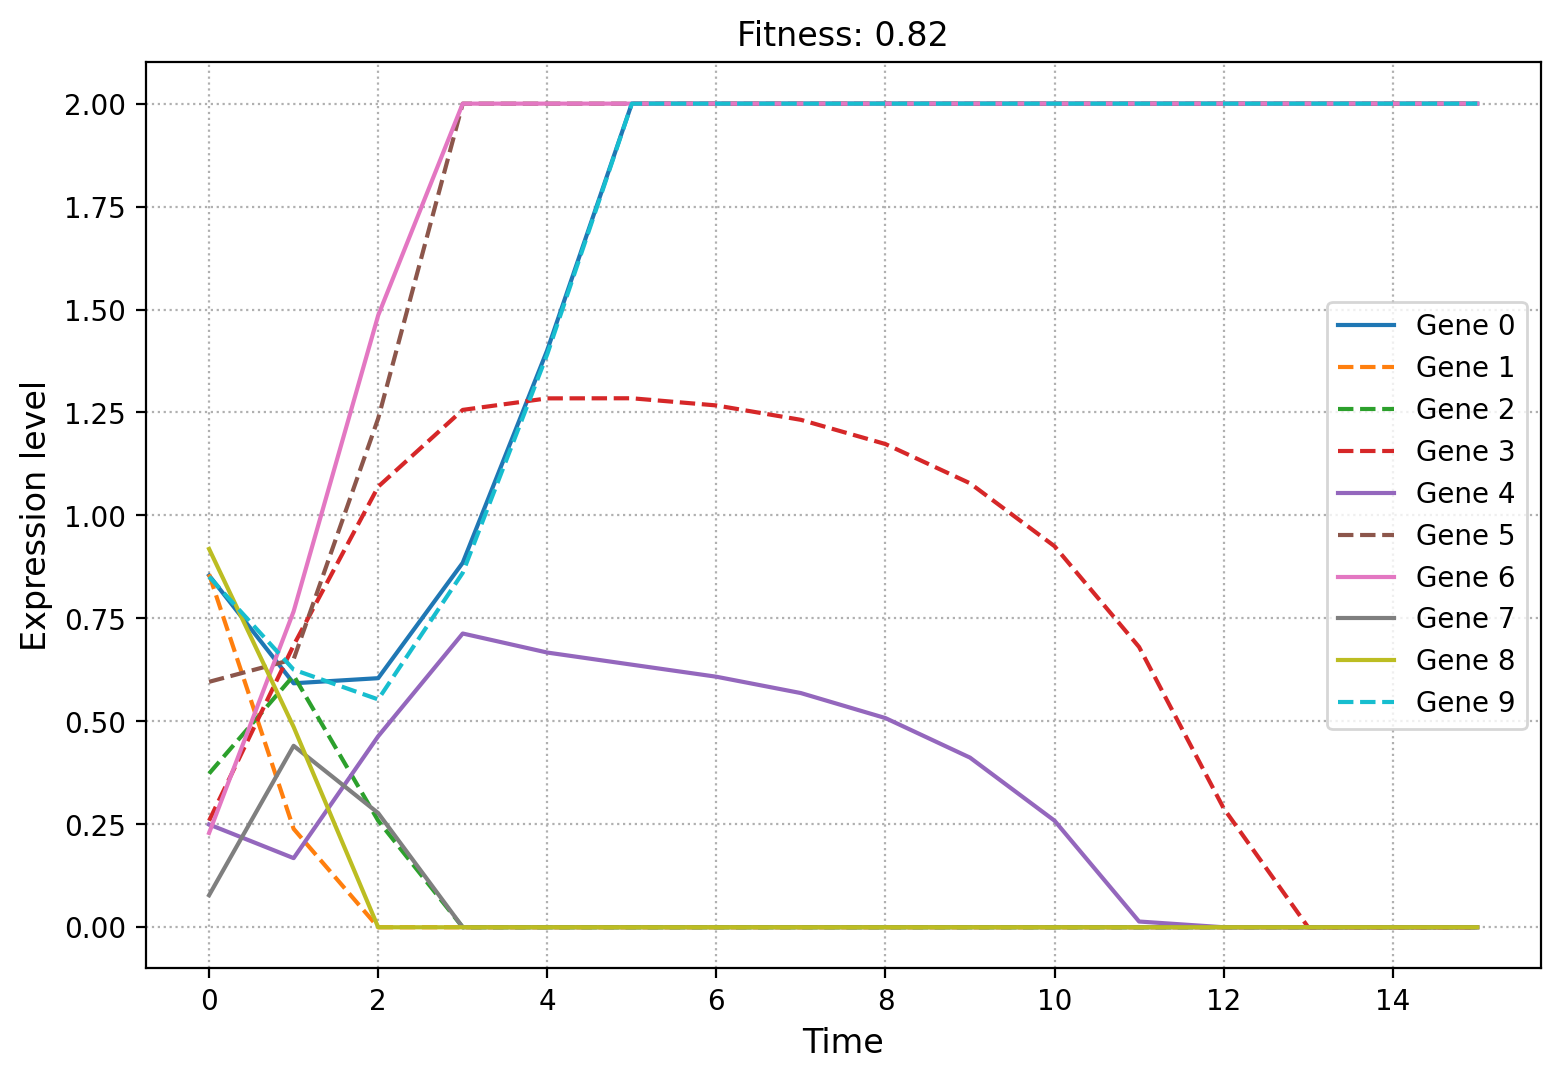

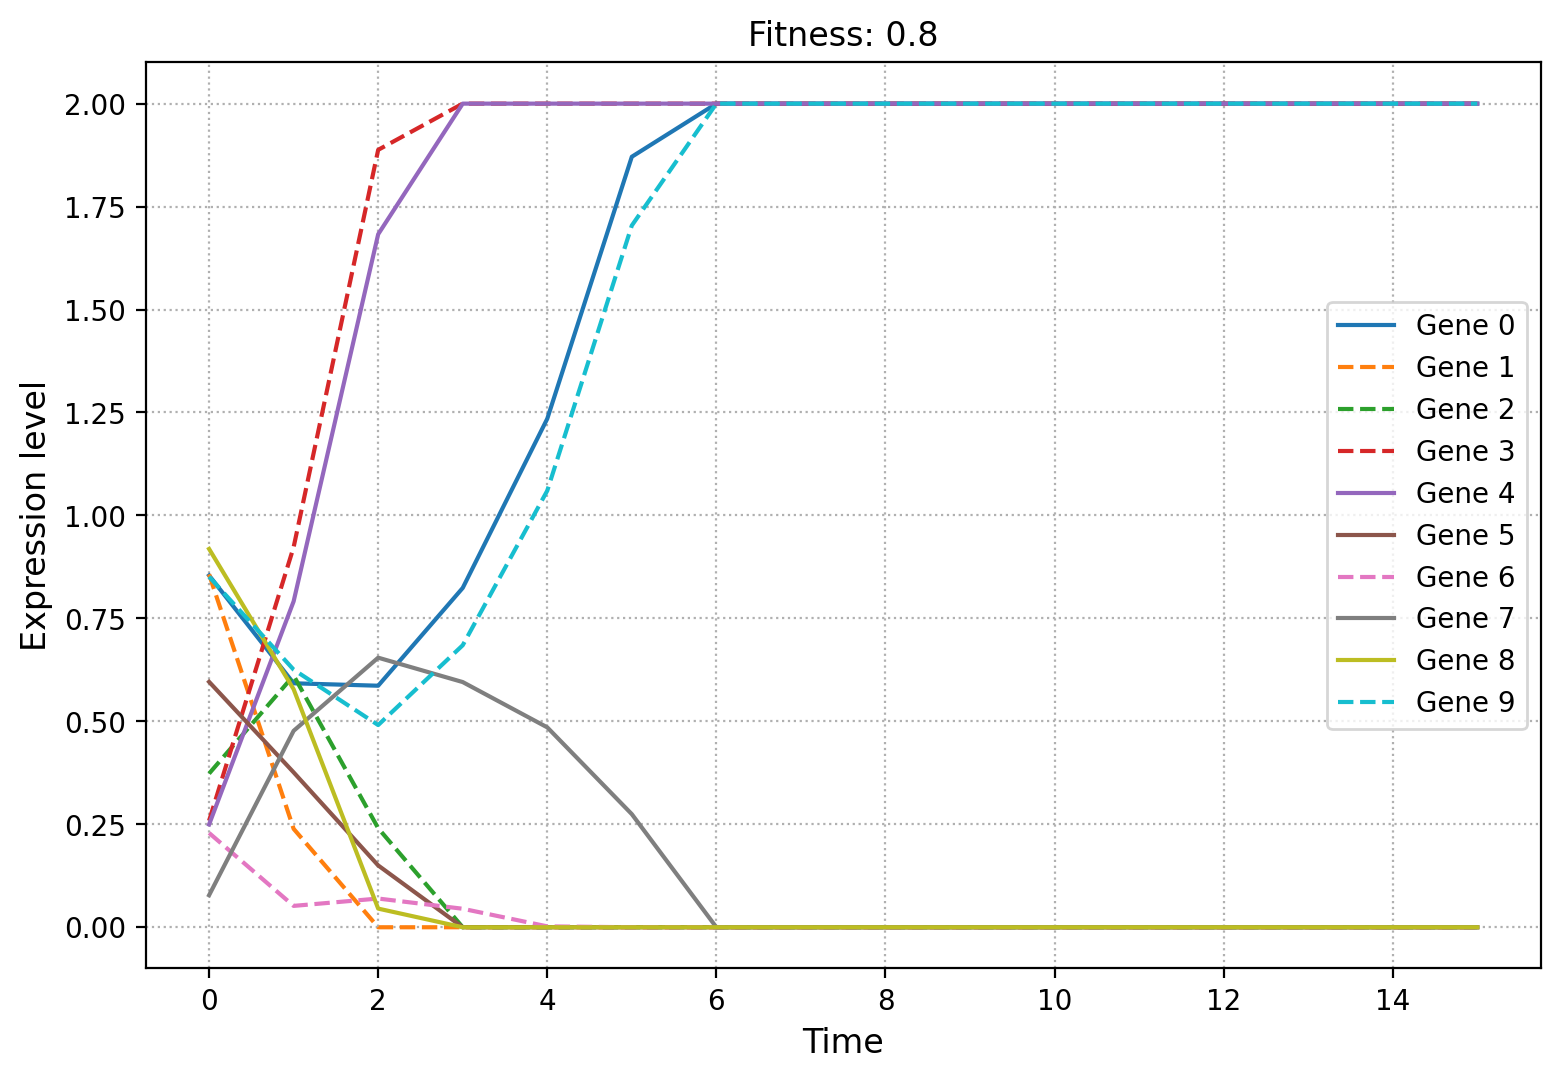

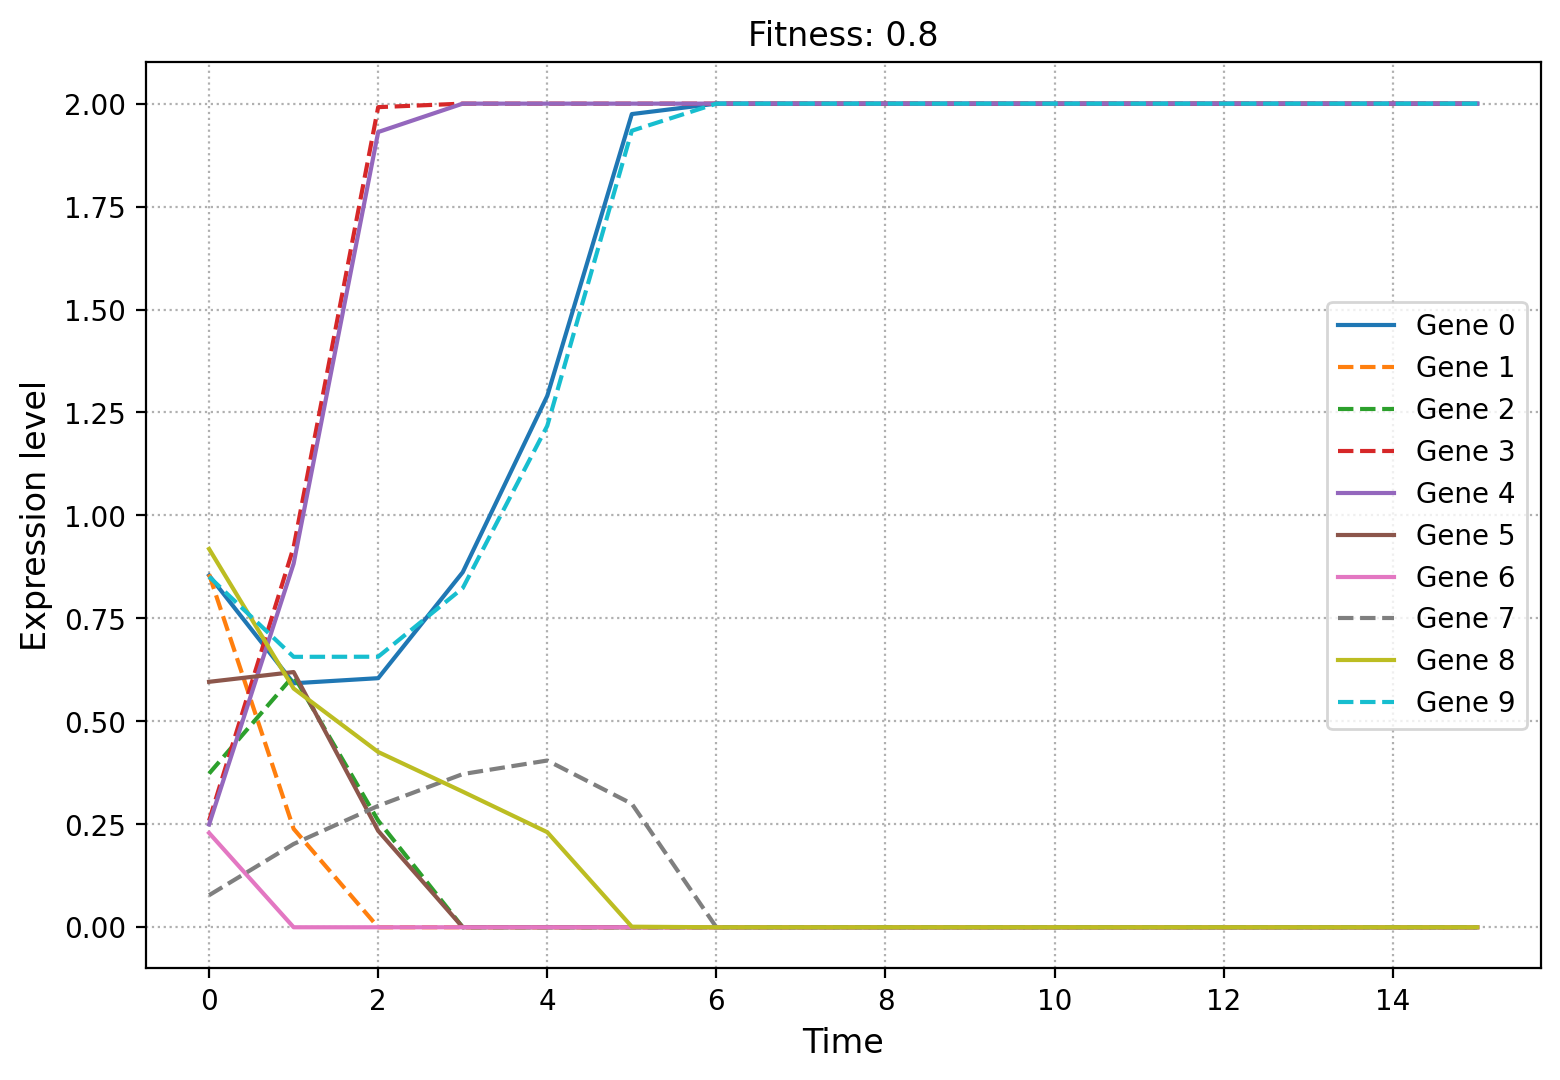

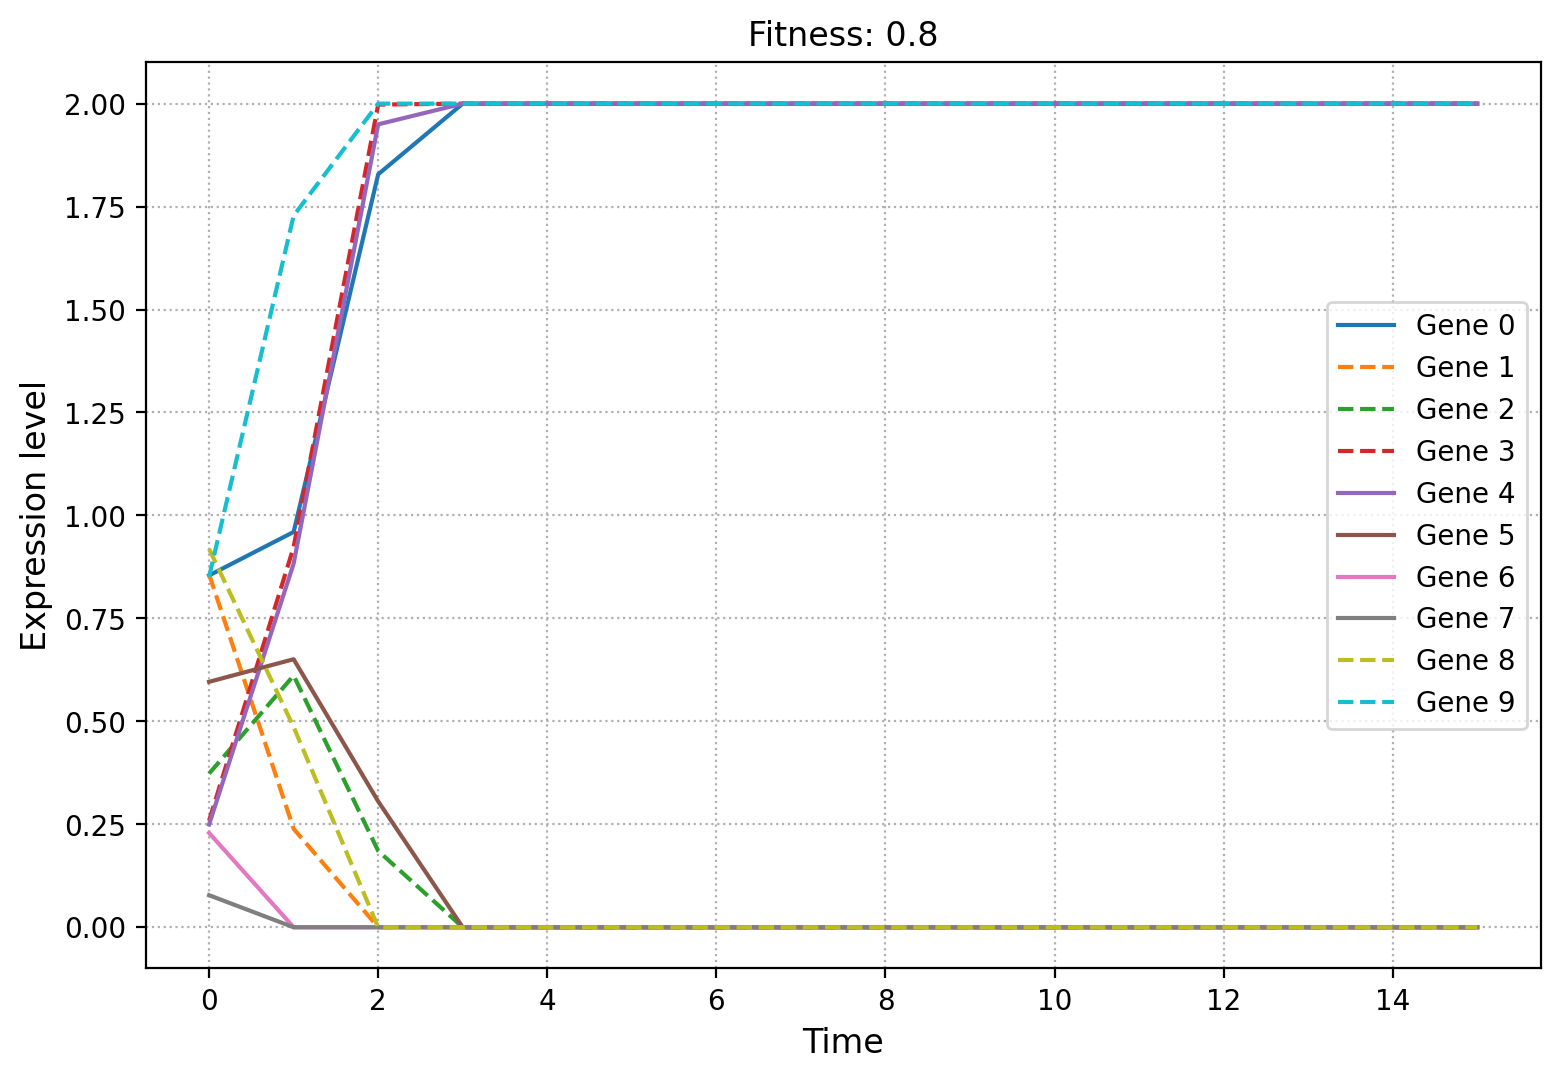

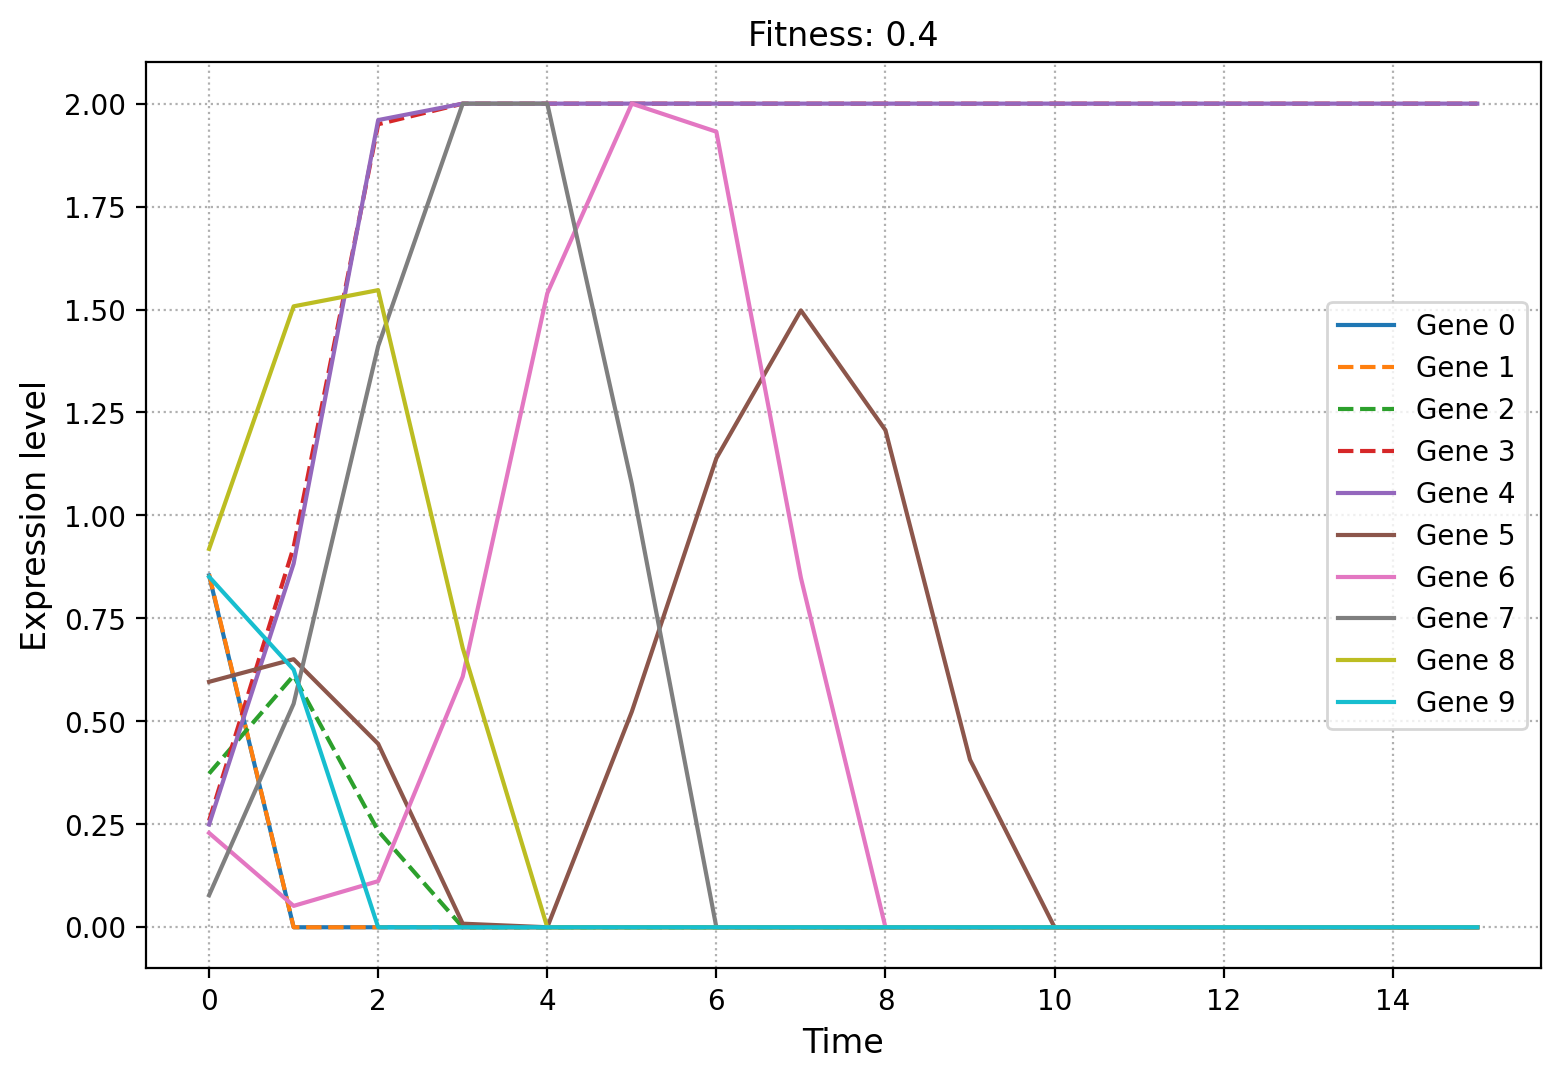

In [11]:
switch_1_gene(indiv)